# Task 3: Neural Machine Translation (45%)

Develop a character-based model that train to translate characters into the target language. 
Compare  the  results  by  this  model  with  the  achieved  results  from  the  word-based  models 
before.

This notebook considers that data has already been preprocessed and the Notebook "Project 2_6.ipynb" has been run.

In [ ]:
import codecs
from tensorflow.keras.callbacks import EarlyStopping
import embedding_models
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import create_model
from keras.layers import * 
import keras
import evaluation
from keras.models import Model
from keras.layers import Input, LSTM, Dense,Embedding
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tabulate

## Load preprocessed training and testing data

In [2]:
with codecs.open("./data/test_eng", 'r', encoding='utf-8') as f:
        test_eng = [line.strip() for line in f.readlines()]
with codecs.open("./data/test_pt", 'r', encoding='utf-8') as f:
        test_pt = [line.strip() for line in f.readlines()]
        
with codecs.open("./data/train_eng", 'r', encoding='utf-8') as f:
        train_eng = [line.strip() for line in f.readlines()]
with codecs.open("./data/train_pt", 'r', encoding='utf-8') as f:
        train_pt = [line.strip() for line in f.readlines()]

## Vektorization and Padding

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

for input_text, target_text in zip(train_eng, train_pt):
    target_text = '<' + target_text + '>'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [4]:
# Calculate the 90th percentile of sentence lengths in characters
eng_lengths_char = [len(sentence) for sentence in input_texts]
pt_lengths_char = [len(sentence) for sentence in target_texts]

percentile_90_eng_char = np.percentile(eng_lengths_char, 90)
percentile_90_pt_char = np.percentile(pt_lengths_char, 90)

print(f"90th percentile sentence length in characters for English: {percentile_90_eng_char}")
print(f"90th percentile sentence length in characters for Portuguese: {percentile_90_pt_char}")

num_eng_below_90th_char = sum(length <= percentile_90_eng_char for length in eng_lengths_char)
num_pt_below_90th_char = sum(length <= percentile_90_pt_char for length in pt_lengths_char)

total_eng_sentences_char = len(eng_lengths_char)
total_pt_sentences_char = len(pt_lengths_char)

print(f"Number of English sentences at or below 90th percentile (character level): {num_eng_below_90th_char}")
print(f"Total number of English sentences: {total_eng_sentences_char}")

print(f"Number of Portuguese sentences at or below 90th percentile (character level): {num_pt_below_90th_char}")
print(f"Total number of Portuguese sentences: {total_pt_sentences_char}")

# Set max length based on 90th percentile in characters
pt_max_len_char = int(percentile_90_pt_char)
en_max_len_char = int(percentile_90_eng_char)

print(f"Maximum sentence length for Portuguese (characters): {pt_max_len_char}")
print(f"Maximum sentence length for English (characters): {en_max_len_char}")


90th percentile sentence length in characters for English: 261.0
90th percentile sentence length in characters for Portuguese: 280.0
Number of English sentences at or below 90th percentile (character level): 72084
Total number of English sentences: 80000
Number of Portuguese sentences at or below 90th percentile (character level): 72034
Total number of Portuguese sentences: 80000
Maximum sentence length for Portuguese (characters): 280
Maximum sentence length for English (characters): 261


In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)+1
num_decoder_tokens = len(target_characters)+1


print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", en_max_len_char)
print("Max sequence length for outputs:", pt_max_len_char)

In [5]:

# Tokenizers for character-level encoding
input_tokenizer = Tokenizer(char_level=True)
target_tokenizer = Tokenizer(char_level=True)

# Fit tokenizers on the text data
input_tokenizer.fit_on_texts(input_texts)
target_tokenizer.fit_on_texts(target_texts)

# Convert text sequences to integer sequences
train_eng_seq = input_tokenizer.texts_to_sequences(input_texts)
train_pt_seq = target_tokenizer.texts_to_sequences(target_texts)

# Pad sequences to the max length
train_eng_seq_padded = pad_sequences(train_eng_seq, maxlen=en_max_len_char, padding='post')
train_pt_seq_padded = pad_sequences(train_pt_seq, maxlen=pt_max_len_char, padding='post')


In [6]:
# Create input and target sequences for the model
train_pt_seq_input = train_pt_seq_padded[:, :-1]
train_pt_seq_target = train_pt_seq_padded[:, 1:]

## Load averaged GloVe embeddings as Char Embeddings

In [21]:
# Load the character embeddings
# we created character-level embeddings by averaging the pre-trained GloVe embeddings for characters present in words
char_embedding_index = embedding_models.load_char_embeddings()
char_embedding_eng = embedding_models.apply_embedding_matrix(char_embedding_index, input_tokenizer, 100)
char_embedding_index = embedding_models.load_char_embeddings(language="portuguese")
char_embedding_pt = embedding_models.apply_embedding_matrix(char_embedding_index, target_tokenizer, 100)

## Train the Model

In [23]:
model  = create_model.create_seq2seq_charlevel_model(
    name="seq2seq_charlevel",
    source_vocab_size=len(input_tokenizer.word_index)+1,  # Add 1 for the 0 index
    target_vocab_size=len(target_tokenizer.word_index)+1,
    embedding_matrix_encoder=char_embedding_eng,
    embedding_matrix_decoder=char_embedding_pt,
    max_len_encoder=en_max_len_char,
    max_len_decoder=pt_max_len_char-1,  # Subtracting 1 to shift the target by 1 position
    embedding_dim=100,
    latent_dim=256
)
callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])


In [ ]:
history = model.fit([train_eng_seq_padded, train_pt_seq_input],
                    train_pt_seq_target,
                    epochs=20, # increased training time for character-level model to get remotely decent results
                    batch_size=128, # increased batch size to speed up training
                    validation_split=0.2,
                    callbacks=[callback])

model.save('models\char-based-model.h5')


## Evaluation

In [ ]:

# Encoder model
encoder_inputs = model.input[0]
encoder_embedding = model.layers[2](encoder_inputs)
encoder_lstm = model.layers[4]
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Define encoder states
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.load_weights('models\char-based-model.h5')

# Decoder model
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = model.layers[3](decoder_inputs_single)  

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs, h, c = model.layers[5](decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]
decoder_outputs = model.layers[6](decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [ ]:
# prepare training data
test_eng_seq = input_tokenizer.texts_to_sequences(test_eng)
test_eng_seq_padded = pad_sequences(test_eng_seq, maxlen=en_max_len_char, padding='post')

In [ ]:
idx2word_target = {v:k for k, v in target_tokenizer.word_index.items()} # index to word mapping for target language
word2idx_outputs = target_tokenizer.word_index

evaluation_df = evaluation.translate_dataset(
    test_eng_seq_padded,       # Test dataset as sequenced inputs
    test_eng,           # List of source sentences in English
    test_pt,            # List of reference translations in Portuguese
    encoder_model,      # Encoder model
    decoder_model,      # Decoder model
    idx2word_target,    # Index-to-word mapping for Portuguese
    pt_lengths_char-1,         # Maximum length of the target sequence
    word2idx_outputs,   # Word-to-index mapping for Portuguese
    save_interval=100,  # Save progress every 100 sentences
    save_path='translation_charmodel_raw.csv',  # Path to save the file
    starttoken='<',
    endtoken='>'
)

# Display the first few rows of the DataFrame
print(evaluation_df.head())

In [ ]:
evaluation_df = evaluation.calculate_scores(evaluation_df)
# Save and display results
evaluation_df.to_csv('translations/translation_charmodel.csv', index=False)
print(evaluation_df.head())

# Results

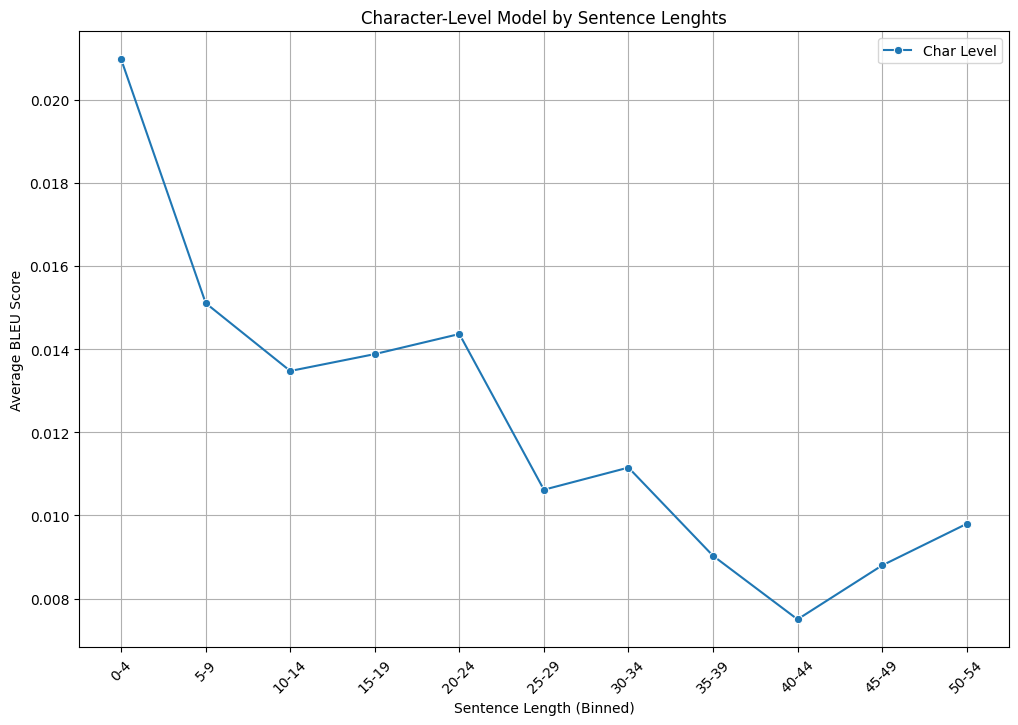

<Figure size 640x480 with 0 Axes>

In [8]:
### Plotting BLEU Score vs. Sentence Length
evaluation_df_wordbased = pd.read_csv('translations/rnn_en_to_pt_glove_wordlevel.csv')
evaluation_df = pd.read_csv('translations/translation_charmodel.csv')

evaluation_df['Sentence Length'] = evaluation_df['Source Sentence'].apply(lambda x: len(str(x).split()))

bins = np.arange(0, 60, 5)  

evaluation_df['Binned Length'] = pd.cut(evaluation_df['Sentence Length'], bins)

char_avg_bleu = evaluation_df.groupby('Binned Length')['BLEU Score'].mean().reset_index()

char_avg_bleu['Binned Length'] = char_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")

plt.figure(figsize=(12, 8))
sns.lineplot(data=char_avg_bleu, x='Binned Length', y='BLEU Score', label='Char Level', marker='o')

plt.title('Character-Level Model by Sentence Lenghts')
plt.xlabel('Sentence Length (Binned)')
plt.ylabel('Average BLEU Score')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

plt.savefig('plot/charmodel_bleu_per_sentencelength.png')

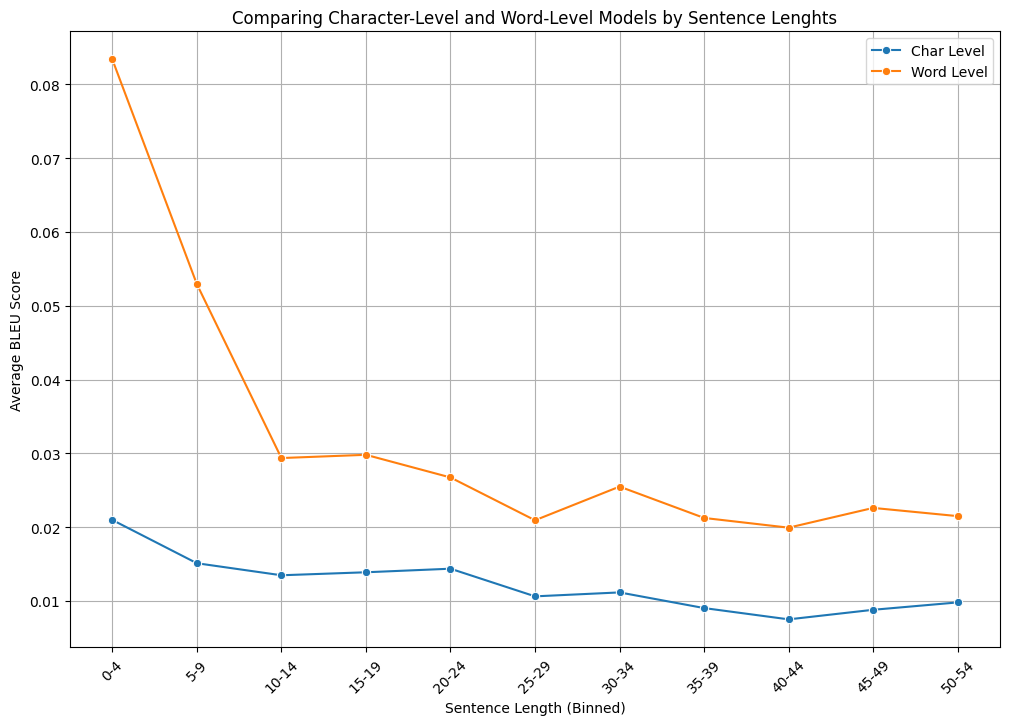

<Figure size 640x480 with 0 Axes>

In [7]:
### Plotting BLEU Score vs. Sentence Length
evaluation_df_wordbased = pd.read_csv('translations/rnn_en_to_pt_glove_wordlevel.csv')
evaluation_df = pd.read_csv('translations/translation_charmodel.csv')

evaluation_df['Sentence Length'] = evaluation_df['Source Sentence'].apply(lambda x: len(str(x).split()))
evaluation_df_wordbased['Sentence Length'] = evaluation_df_wordbased['Source Sentence'].apply(lambda x: len(str(x).split()))

bins = np.arange(0, 60, 5)  

evaluation_df['Binned Length'] = pd.cut(evaluation_df['Sentence Length'], bins)
evaluation_df_wordbased['Binned Length'] = pd.cut(evaluation_df_wordbased['Sentence Length'], bins)

char_avg_bleu = evaluation_df.groupby('Binned Length')['BLEU Score'].mean().reset_index()
word_avg_bleu = evaluation_df_wordbased.groupby('Binned Length')['BLEU Score'].mean().reset_index()

char_avg_bleu['Binned Length'] = char_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")
word_avg_bleu['Binned Length'] = word_avg_bleu['Binned Length'].apply(lambda x: f"{int(x.left)}-{int(x.right-1)}")

plt.figure(figsize=(12, 8))
sns.lineplot(data=char_avg_bleu, x='Binned Length', y='BLEU Score', label='Char Level', marker='o')
sns.lineplot(data=word_avg_bleu, x='Binned Length', y='BLEU Score', label='Word Level', marker='o')

plt.title('Comparing Character-Level and Word-Level Models by Sentence Lenghts')
plt.xlabel('Sentence Length (Binned)')
plt.ylabel('Average BLEU Score')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)

plt.show()

plt.savefig('plot/charmodel_vs_wordmodel_bleu_per_sentencelength.png')

In [17]:
word_stats = {
    'Metric': ['BLEU Mean', 'BLEU Std Dev', 'BLEU 50%',  'BLEU Max', 'METEOR Mean', 'METEOR Std Dev',  'METEOR 50%',  'METEOR Max'],
    'Word-based': [
        evaluation_df_wordbased['BLEU Score'].mean(),
        evaluation_df_wordbased['BLEU Score'].std(),
        evaluation_df_wordbased['BLEU Score'].median(),
        evaluation_df_wordbased['BLEU Score'].max(),
        evaluation_df_wordbased['METEOR Score'].mean(),
        evaluation_df_wordbased['METEOR Score'].std(),
        evaluation_df_wordbased['METEOR Score'].median(),
        evaluation_df_wordbased['METEOR Score'].max()
    ]
}

char_stats = {
    'Metric': ['BLEU Mean', 'BLEU Std Dev', 'BLEU 50%',  'BLEU Max', 'METEOR Mean', 'METEOR Std Dev', 'METEOR 50%', 'METEOR Max'],
    'Character-based': [
        evaluation_df['BLEU Score'].mean(),
        evaluation_df['BLEU Score'].std(),
        evaluation_df['BLEU Score'].median(),
        evaluation_df['BLEU Score'].max(),
        evaluation_df['METEOR Score'].mean(),
        evaluation_df['METEOR Score'].std(),
        evaluation_df['METEOR Score'].median(),
        evaluation_df['METEOR Score'].max()
    ]
}

word_df = pd.DataFrame(word_stats)
char_df = pd.DataFrame(char_stats)

comparison_df = pd.merge(word_df, char_df, on='Metric')

comparison_df

,Metric,Word-based,Character-based
0,BLEU Mean,0.030149,0.012591
1,BLEU Std Dev,0.056600,0.014909
2,BLEU 50%,0.017205,0.009721
3,BLEU Max,0.866878,0.241807
4,METEOR Mean,0.147865,0.086066
5,METEOR Std Dev,0.097056,0.054837
6,METEOR 50%,0.130435,0.078431
7,METEOR Max,0.976471,0.371904
